In [25]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms


In [5]:
#Download kaggle data using kagglehub

path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")
print("Dataset downloaded at path:", path)

src = path
print(os.listdir(src))

Dataset downloaded at path: /Users/kuldeeppatel/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12
['pred', '.DS_Store', 'no', 'Br35H-Mask-RCNN', 'yes', 'BT2.jpg']


In [ ]:

src = "/Users/kuldeeppatel/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12"

target = "/Users/kuldeeppatel/Desktop/brain_tumor_dataset_split"

classes = ["yes", "no"]

# Create folder structure locally
for split in ["train", "test", "validate"]:
    for cls in classes:
        os.makedirs(f"{target}/{split}/{cls}", exist_ok=True)

# Split and copy images
for cls in classes:
    class_path = os.path.join(src, cls)
    files = [f for f in os.listdir(class_path)
            if f.lower().endswith(("jpg", "jpeg", "png"))]

    # 80% train, 10% test, 10% val
    train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42)
    test_files, val_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Copy images
    for f in train_files:
        shutil.copy(os.path.join(class_path, f), f"{target}/train/{cls}/")
    for f in test_files:
        shutil.copy(os.path.join(class_path, f), f"{target}/test/{cls}/")
    for f in val_files:
        shutil.copy(os.path.join(class_path, f), f"{target}/validate/{cls}/")

print("Dataset split complete!")
print("New dataset saved at:", target)

Dataset split complete!
New dataset saved at: /Users/kuldeeppatel/Desktop/brain_tumor_dataset_split


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [6]:
#Load Dataset

train_dir = f"{target}/train"
test_dir = f"{target}/test"
val_dir = f"{target}/validate"

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

print("Class Mapping:", train_dataset.class_to_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

Class Mapping: {'no': 0, 'yes': 1}


In [ ]:
from torch.nn.modules.activation import Sigmoid
#DEFINE CNN MODEL

class BrainTumorCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Conv2d(1,32,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Conv2d(64,128,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Flatten(),

        nn.Linear(128*28*28 , 128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, 64),
        nn.ReLU(),

        nn.Linear(64, 32),
        nn.ReLU(),

        nn.Linear(32, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.model(x)

In [8]:
#Training setup

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BrainTumorCNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}


In [9]:
#Training and Validation

for epoch in range (num_epochs):
  model.train()
  train_loss, correct, total = 0,0,0

  for imgs, labels in train_loader:
    imgs, labels = imgs.to(device), labels.float().to(device)

    optimizer.zero_grad()
    outputs = model(imgs).squeeze()       #This makes shapes match for loss calculation. Since this is binary classification, outputs are values between 0 and 1 (after sigmoid)

    loss = criterion(outputs, labels)
    loss.backward()                       #computes the gradient
    optimizer.step()                      #updates the model’s weights based on gradients.

    train_loss += loss.item()
    pred = (outputs > 0.5).float()
    correct += (pred == labels).sum().item()
    total += labels.size(0)

  train_acc = correct / total

  # VALIDATION

  model.eval()
  val_loss, val_correct, val_total = 0,0,0

  with torch.no_grad():                 #Disable Gradient Calculation, which Speeds up validation.
    for imgs, labels in val_loader:
      imgs, labels = imgs.to(device), labels.float().to(device)
      outputs = model(imgs).squeeze()

      loss = criterion(outputs, labels)
      val_loss += loss.item()

      preds = (outputs > 0.5).float()
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

  val_acc = val_correct / val_total

  history["loss"].append(train_loss / len(train_loader))
  history["val_loss"].append(val_loss / len(val_loader))
  history["acc"].append(train_acc)
  history["val_acc"].append(val_acc)

  print(f"Epoch {epoch+1}/{num_epochs} | "
  f"Train Loss={train_loss/len(train_loader):.4f} | "
  f"Val Loss={val_loss/len(val_loader):.4f} | "
  f"Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")


Epoch 1/25 | Train Loss=0.6101 | Val Loss=0.4782 | Train Acc=0.6621 | Val Acc=0.7933
Epoch 2/25 | Train Loss=0.4511 | Val Loss=0.3608 | Train Acc=0.7992 | Val Acc=0.8600
Epoch 3/25 | Train Loss=0.3201 | Val Loss=0.2465 | Train Acc=0.8625 | Val Acc=0.9033
Epoch 4/25 | Train Loss=0.2340 | Val Loss=0.2057 | Train Acc=0.9038 | Val Acc=0.9167
Epoch 5/25 | Train Loss=0.1727 | Val Loss=0.1353 | Train Acc=0.9325 | Val Acc=0.9533
Epoch 6/25 | Train Loss=0.1488 | Val Loss=0.0967 | Train Acc=0.9467 | Val Acc=0.9767
Epoch 7/25 | Train Loss=0.1048 | Val Loss=0.0907 | Train Acc=0.9671 | Val Acc=0.9767
Epoch 8/25 | Train Loss=0.0733 | Val Loss=0.0835 | Train Acc=0.9779 | Val Acc=0.9767
Epoch 9/25 | Train Loss=0.0866 | Val Loss=0.0793 | Train Acc=0.9712 | Val Acc=0.9867
Epoch 10/25 | Train Loss=0.0675 | Val Loss=0.0865 | Train Acc=0.9783 | Val Acc=0.9667
Epoch 11/25 | Train Loss=0.0513 | Val Loss=0.0755 | Train Acc=0.9850 | Val Acc=0.9800
Epoch 12/25 | Train Loss=0.0516 | Val Loss=0.0705 | Train Acc=0

In [10]:
#Test set evaluation

def evaluate(loader):
  model.eval()
  correct, total = 0,0

  with torch.no_grad():
    for imgs, labels in loader:
      imgs, labels = imgs.to(device), labels.float().to(device)
      preds = (model(imgs).squeeze() > 0.5).float()
      correct += (preds==labels).sum().item()
      total += labels.size(0)
  return correct/total

print("Final Test Accuracy:", evaluate(test_loader))


Final Test Accuracy: 0.9733333333333334


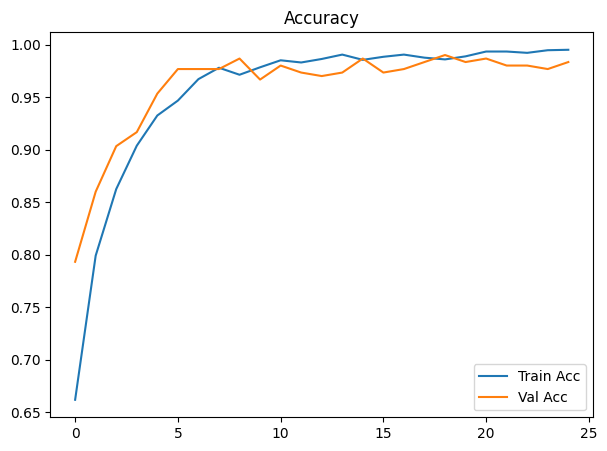

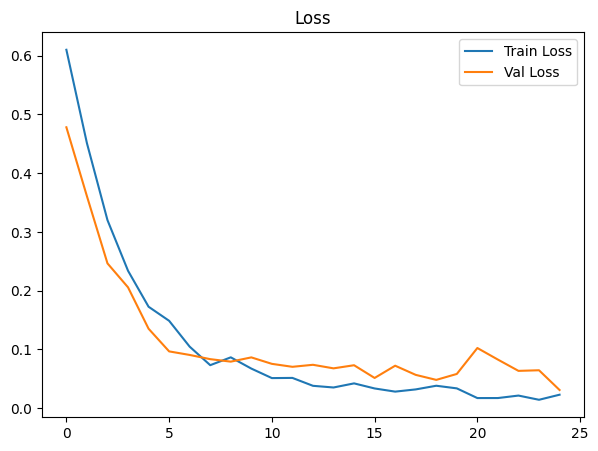

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(history["acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.figure(figsize=(7,5))
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.show()

In [ ]:
#random prediction for test set

def show_prediction(folder, filename):
    img_path = os.path.join(folder, filename)
    img = Image.open(img_path).convert("L")

    # Preprocess image
    tensor_img = transform(img).unsqueeze(0).to(device)

    # Model prediction
    with torch.no_grad():
        pred = model(tensor_img).item()

    # Classification threshold
    result = "Tumor" if pred > 0.5 else "No Tumor"
    label = 1 if pred > 0.5 else 0   # <-- ADD THIS LINE
    print("Predicted Label:", label) # <-- PRINTS 1 OR 0
    color = "red" if result == "Tumor" else "green"

    # Show image
    plt.imshow(np.array(img), cmap="gray")
    plt.title(f"Predicted: {result}", color=color)
    plt.axis("off")


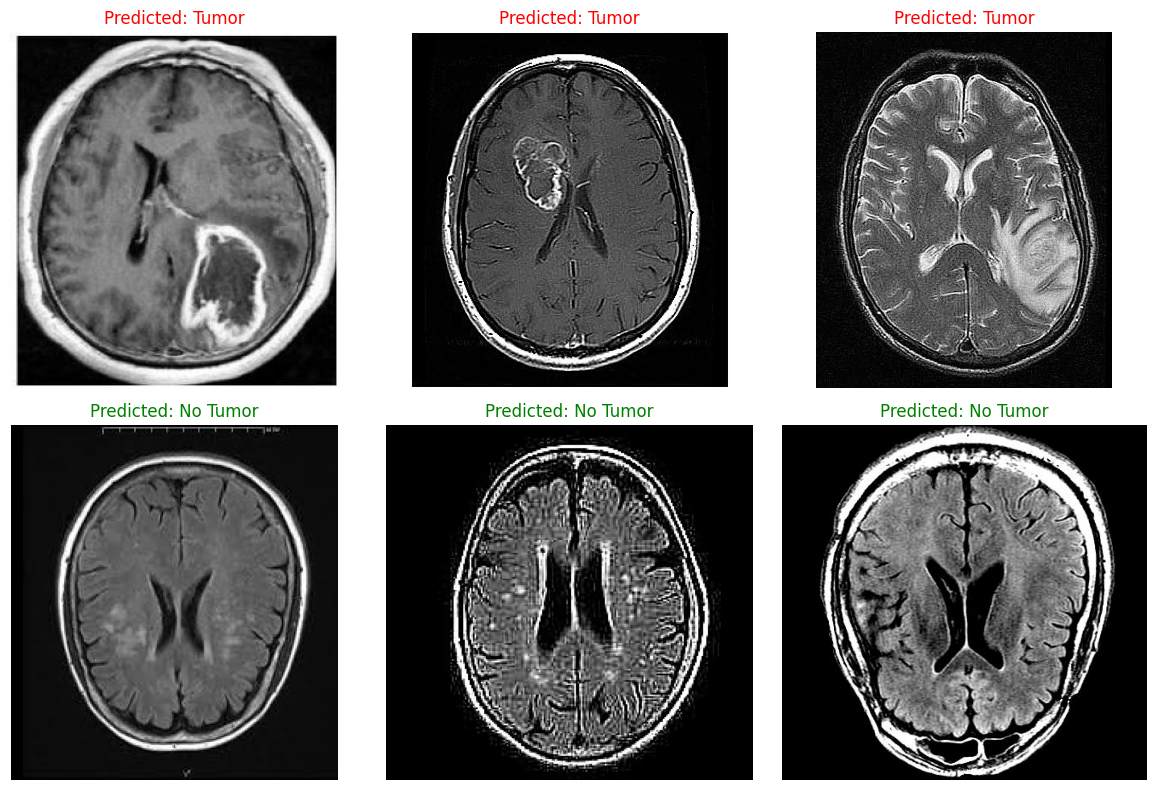

In [13]:
yes_imgs = random.sample(os.listdir(os.path.join(test_dir, "yes")), 3)
no_imgs  = random.sample(os.listdir(os.path.join(test_dir, "no")), 3)

plt.figure(figsize=(12, 8))

for i, img_name in enumerate(yes_imgs):
    plt.subplot(2, 3, i+1)
    show_prediction(os.path.join(test_dir, "yes"), img_name)

for i, img_name in enumerate(no_imgs):
    plt.subplot(2, 3, i+4)
    show_prediction(os.path.join(test_dir, "no"), img_name)

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "/Users/kuldeeppatel/Desktop/Brain_Tumor_CNN/brain_tumor_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [20]:
from torch.nn.modules.activation import Sigmoid
#DEFINE CNN MODEL

class BrainTumorCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Conv2d(1,32,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Conv2d(64,128,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Flatten(),

        nn.Linear(128*28*28 , 128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, 64),
        nn.ReLU(),

        nn.Linear(64, 32),
        nn.ReLU(),

        nn.Linear(32, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.model(x)

In [28]:


model = BrainTumorCNN()          # create model object
model.load_state_dict(torch.load("/Users/kuldeeppatel/Desktop/brain_tumor_dataset_split/brain_tumor_model.pth",))
model.eval()                     # set to evaluation mode


BrainTumorCNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=100352, out_features=128, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17): ReLU()
    (18): Linear(in_features=64, out_features=32, bias=True)
    (19):

In [37]:
#random prediction for test set

def show_prediction(folder, filename):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    img_path = os.path.join(folder, filename)
    img = Image.open(img_path).convert("L")

    # Preprocess image
    tensor_img = transform(img).unsqueeze(0).to(device)

    # Model prediction
    with torch.no_grad():
        pred = model(tensor_img).item()

    # Classification threshold
    result = "Tumor" if pred > 0.5 else "No Tumor"
    label = 1 if pred > 0.5 else 0   # <-- ADD THIS LINE
    print("Predicted Label:", label, "Chances:", pred) # <-- PRINTS 1 OR 0
    color = "red" if result == "Tumor" else "green"

    # Show image
    plt.imshow(np.array(img), cmap="gray")
    plt.title(f"Predicted: {result}", color=color)
    plt.axis("off")


Predicted Label: 0 Chances: 1.0306972289542138e-11


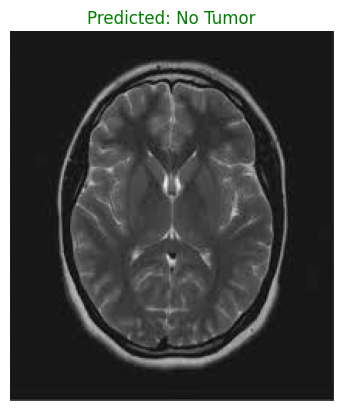

In [45]:
yes_folder = "/Users/kuldeeppatel/Desktop"
filename = "bt.jpg" 

show_prediction(yes_folder, filename)
# or any filename inside the yes folder
